In [1]:
%matplotlib widget

In [2]:
%load_ext autoreload
%autoreload 2
from sage.all import *
from utility import *

Pi = sage.symbolic.constants.pi

In [3]:
# Define here the equation defining your affine variety.
x,y,z,w = var('x, y, z, w', domain=CC)


X = x*y*z + x^2 + y^2 +  y -1
print(X)


x*y*z + x^2 + y^2 + y - 1


In [4]:
# Check if X is smooth
X_vars = [x,y,z]
constraints = [X.diff(var) == 0 for var in X_vars]
solutions = solve(constraints, X_vars, solution_dict=True)
singularities = [point for point in solutions if X.subs(point).is_zero()]


if singularities:
    print(f"The variety is singular at the following points: {singularities}")
else:
    print("The variety is smooth.")

# Check if is_zero is reliable: Distrust the result if below values are close to 0.
for point in solutions:
    print(X.subs(point))

The variety is smooth.
-5/4


# Defining the Lefschetz Bifibration

## The fibration $\pi$

The fibre over t in C is 1/15*(10*t + 7*x - y)*x*y + x^2 + y^2 + y - 1 == 0
The model fibre over 0.600000000000000*I is 1/15*(7*x - y + 6.00000000000000*I)*x*y + x^2 + y^2 + y - 1 == 0
Critical values: 7 
Critical points: 7


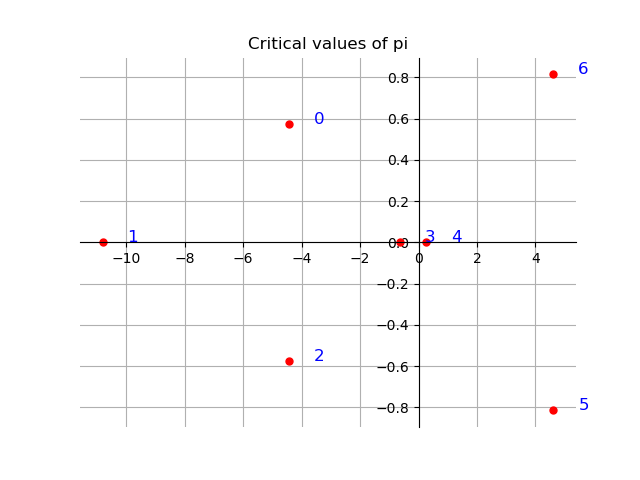

In [18]:
alpha, beta, gamma = var('alpha, beta, gamma', domain=CC)
pi = alpha*x + beta*y + gamma*z


pi = pi.subs({
    alpha: -0.7,
    beta: 0.1,
    gamma: 1.5
})

pi = LefschetzFibration([x,y,z], X, pi)
origin_fibre = 0.6*I
solvefor=z

t = var('t', domain=CC)

t_fibre = pi.get_fibre(t, solvefor)
print(f'The fibre over t in C is {t_fibre.simplify()==0}')
print(f'The model fibre over {origin_fibre} is {t_fibre.simplify().subs({t:origin_fibre})==0}')

crit_values_pi = sort_by_angle(pi.get_critical_values(), origin_fibre)
crit_points_pi = pi.get_critical_points()

print(f'Critical values: {len(crit_values_pi)} \nCritical points: {len(crit_points_pi)}')

plot_points_ordered(crit_values_pi, 'Critical values of pi', origin_fibre=origin_fibre)

### Criticality at Infinity

In [19]:
print(intersection_summary(pi))
intersection = intersection_at_infinity(pi)

for point in intersection:
    print(kernels(pi, point))
    print(point)

The hyperplane at infinity is given by 1.00000000000000*x*y*z == 0.
The fibration vanishes at [-0.700000000000000*x + 0.100000000000000*y + 1.50000000000000*z == 0].
Their intersection consists of [{x: 0, y: 1, z: -1/15, w: 0}, {x: 1, y: 0, z: 7/15, w: 0}, {x: 1, y: 7, z: 0, w: 0}].
None
Vector space of degree 4 and dimension 1 over Symbolic Ring
Basis matrix:
[                  0    1.00000000000000 -0.0666666666666667                   0]
{x: 0, y: 1, z: -1/15, w: 0}
Vector space of degree 4 and dimension 1 over Symbolic Ring
Basis matrix:
[ 1.00000000000000                 0 0.466666666666667                 0]
{x: 1, y: 0, z: 7/15, w: 0}
Vector space of degree 4 and dimension 1 over Symbolic Ring
Basis matrix:
[1.00000000000000 7.00000000000000                0                0]
{x: 1, y: 7, z: 0, w: 0}


## The fibration $\rho$

The expression of rho over t in C is 0.500000000000000*x - 0.0500000000000000*y
Critical values: 6
Critical points: 6


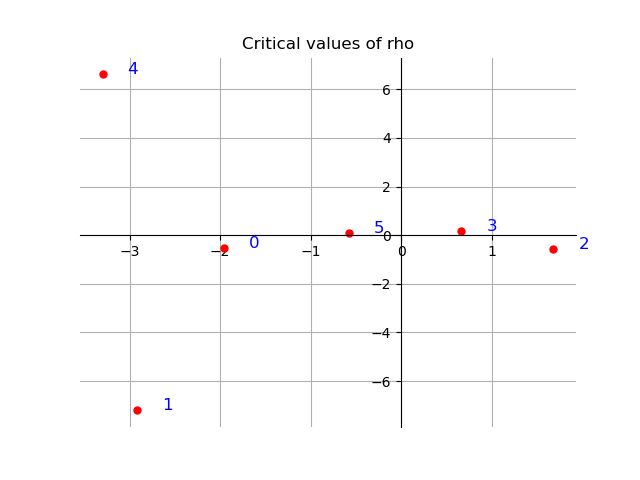

In [23]:
ar = var('ar', domain=CC)
br = var('br', domain=CC)

rho = ar*x + br*y

# rho = rho.subs({ar: 3*e^(2*Pi*I*-0.05).n(), br: 8*e^(2*I*Pi*0.08).n()})

rho = rho.subs({ar: 0.5, br: -0.05})
origin_fibre_rho = 0

rho_t = rho.subs(solvefor == t_fibre)
rho_0 = rho_t.subs(t==origin_fibre)

rho = LefschetzFibration([x,y], t_fibre.subs(t==origin_fibre), rho_0)

crit_points_rho = rho.get_critical_points()
crit_values_rho = sort_by_angle(rho.get_critical_values())

# Somehow crit values is bugging out

# a = var('a', domain=CC)
# constraints = [rho.domain==0]
# gradient_constraints = [rho.domain.diff(variable) == a*rho.fibration.diff(variable) for variable in rho.variables]
# a_solved = solve(gradient_constraints[0], a)[0]
# b = gradient_constraints[0]
# gradient_constraints = [constraint.lhs() - constraint.rhs().subs(a_solved) ==0 for constraint in gradient_constraints[1:]]
# constraints.extend(gradient_constraints)
# print(constraints)

# crit_points_rho = solve(constraints, rho.variables)
# crit_points_rho = [[expression.lhs() == expression.rhs().n() for expression in solution] for solution in crit_points_rho]
# crit_values_rho = sort_by_angle([rho(cpoint) for cpoint in crit_points_rho])

# print(crit_points_rho)

print(f'The expression of rho over t in C is {rho_t}')
print(f'Critical values: {len(crit_values_rho)}')
print(f'Critical points: {len(crit_points_rho)}')
plot_points_ordered(crit_values_rho, origin_fibre=origin_fibre_rho, title="Critical values of rho")


### Vanishing Cycles of Rho

#### Origin Fibre

-1/1500*(3*y - 59.999999999999986*I)*y^2 + 101/100*y^2 + y - 1


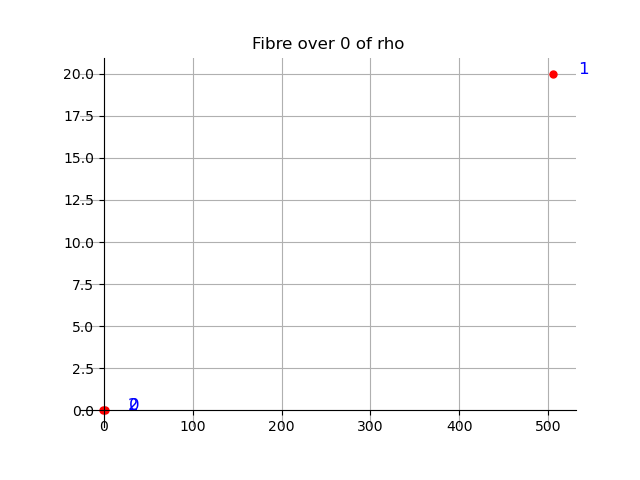

In [24]:
solvefor_rho = x

t_fibre_rho = rho.get_fibre(t,solvefor_rho)
fibre_rho_0 = t_fibre_rho.subs(t==origin_fibre_rho)
print(fibre_rho_0)

sols = NumericalRoots(fibre_rho_0)

plot_points_ordered(sols, origin_fibre=origin_fibre_rho, title="Fibre over 0 of rho")


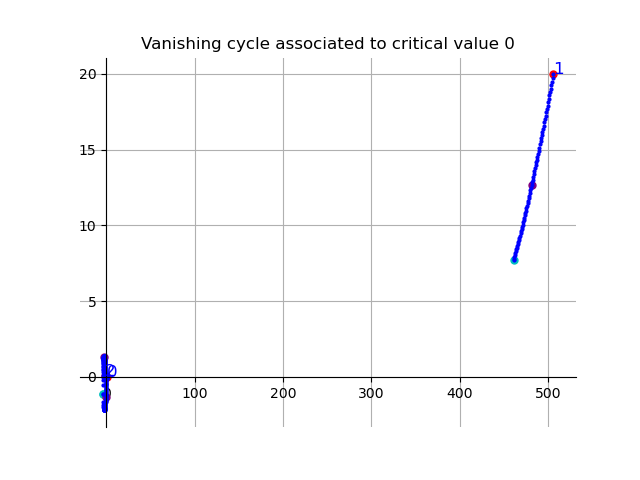

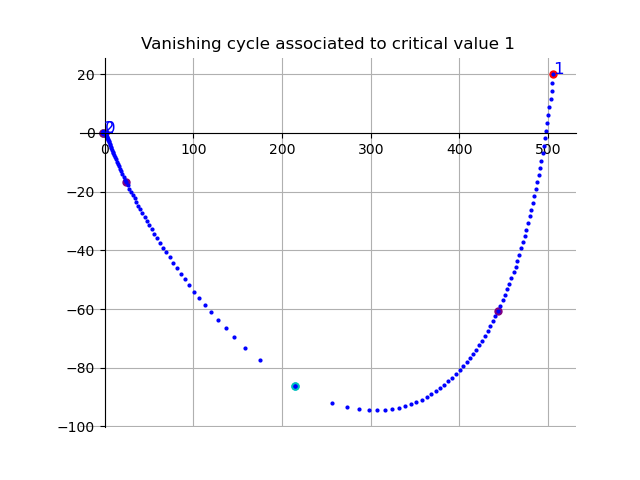

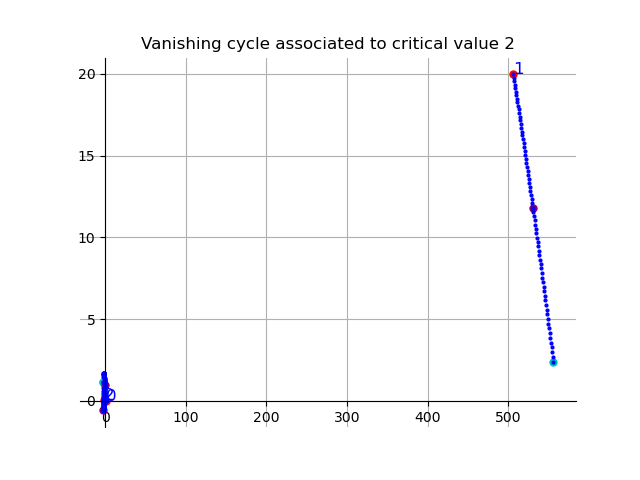

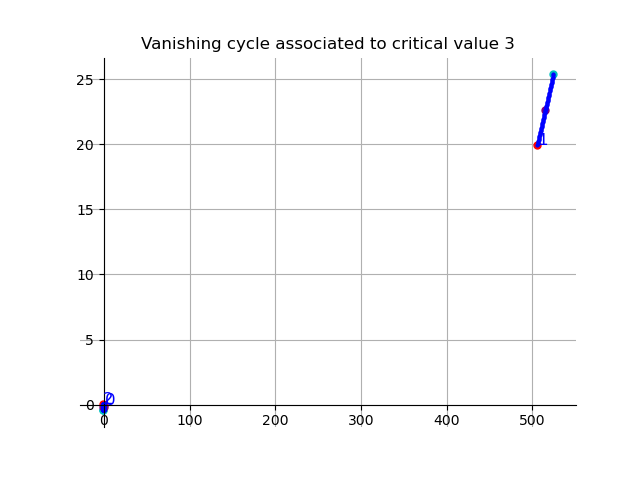

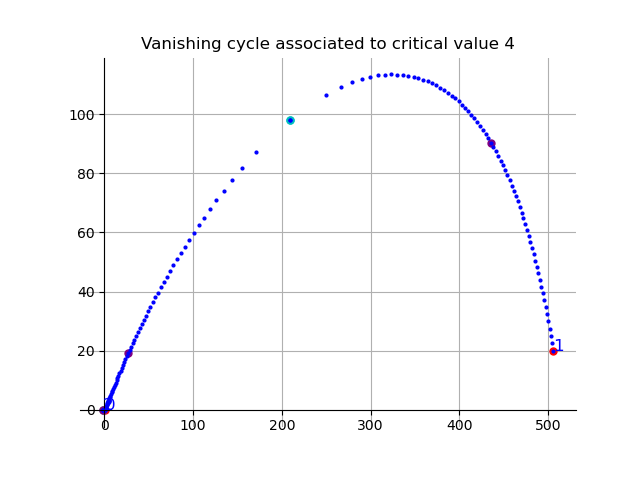

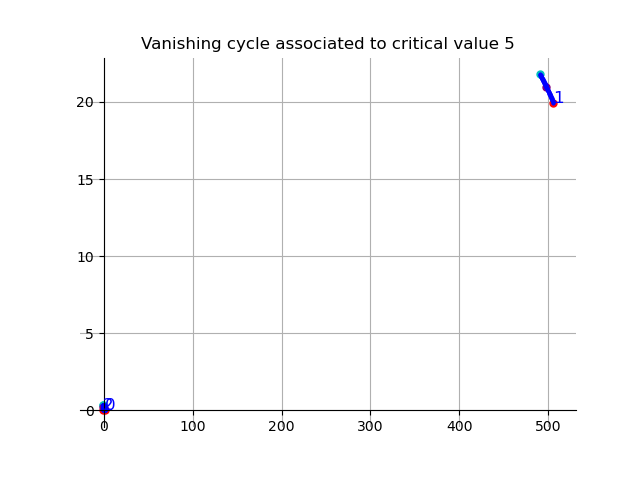

In [25]:
for (index, point) in enumerate(crit_values_rho):
    path = pl_path([origin_fibre_rho, point])
    trace_preimage(rho, t, path, solvefor=solvefor_rho, title=f'Vanishing cycle associated to critical value {index}')    

## Matching Paths - Images of Vanishing Cycles

In [27]:
for index, crit in enumerate(crit_values_pi):
    matching = pi.get_matching_path(rho_0, origin_fibre, crit, solvefor=solvefor, steps=140)
    plot_path_3d(matching, title = f'Matching path to critical value {index} of f', origin_fibre=origin_fibre_rho)

Graphics3d Object

Graphics3d Object

Graphics3d Object

Graphics3d Object

Graphics3d Object

Graphics3d Object

Graphics3d Object